In [1]:
%%bash

pip install torchinfo

In [2]:
import pathlib

import matplotlib.pyplot as plt
import pytorch_lightning as pl
from sklearn import manifold
import torch
from torch import nn, optim, utils
from torch.nn import functional as F
import torchinfo
from torchvision import datasets, transforms

# Data prepartion

In [3]:
%%bash
EXTRACT_DIR=/kaggle/working/data/cassava-disease/unlabeled
mkdir -p $EXTRACT_DIR 
unzip -qo /kaggle/input/cassava-disease/extraimages.zip -d $EXTRACT_DIR
mv $EXTRACT_DIR/extraimages $EXTRACT_DIR/0
rm -r /kaggle/working/data/cassava-disease/unlabeled/__MACOSX/

In [28]:
DATA_DIR = pathlib.Path("/kaggle/working/data/cassava-disease")
INPUT_SHAPE = (3, 32, 32)
INPUT_SIZE = 3 * 32 * 32
CROPPED_SHAPE = INPUT_SHAPE[1:] 
BATCH_SIZE = 64

In [29]:
transform = transforms.Compose([
    transforms.RandomCrop(CROPPED_SHAPE),
    transforms.ToTensor(),
])


unlabeled_dataset = datasets.ImageFolder(
    DATA_DIR / "unlabeled",
    transform=transform
)

train_dataset, val_dataset = utils.data.random_split(
    unlabeled_dataset,
    [10000, 2595]
)

dataloader_kwargs = {
    "batch_size": BATCH_SIZE,
    "num_workers": 4,
}

train_dataloader = utils.data.DataLoader(
    train_dataset,
    shuffle=True,
    **dataloader_kwargs
)

val_dataloader = utils.data.DataLoader(
    val_dataset,
    shuffle=False,
    **dataloader_kwargs
)

predictions_dataloader = utils.data.DataLoader(
    val_dataset,
    shuffle=False,
    **dataloader_kwargs
)

# Performing PCA with an undercomplete linear autoencoder

In [30]:
class PCA(pl.LightningModule):
    
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(INPUT_SIZE, 2),
        )

        self.decoder = nn.Sequential(
            nn.Linear(2, INPUT_SIZE),
            nn.Unflatten(dim=1, unflattened_size=INPUT_SHAPE)
        )

        self.autoencoder = nn.Sequential(
            *self.encoder,
            *self.decoder
        )
        
        self.loss_fn = nn.MSELoss()
        
    def forward(self, X):
        Z = self.autoencoder(X)
        return Z
    
    def training_step(self, batch, batch_idx):
        X, _ = batch
        Z = self.forward(X)
        loss = self.loss_fn(Z, X)
        self.log("train_loss", loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        X, _ = batch
        Z = self.forward(X)
        loss = self.loss_fn(Z, X)
        self.log("val_loss", loss, prog_bar=True)
        return loss
    
    def predict_step(self, batch, batch_idx):
        X, _ = batch
        embeddings = self.encoder(X)
        return embeddings
    
    def configure_optimizers(self):
        return optim.SGD(self.parameters(), lr=1e-3)
        

In [31]:
pca = PCA()

_trainer_kwargs = {
    "max_epochs": 100,
    "callbacks": [
        pl.callbacks.EarlyStopping("val_loss")
    ],
}
trainer = pl.Trainer(**_trainer_kwargs)

trainer.fit(pca, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [32]:
predictions = trainer.predict(pca, dataloaders=val_dataloader)

Predicting: 157it [00:00, ?it/s]

In [33]:
principal_components = torch.cat(predictions, axis=0)

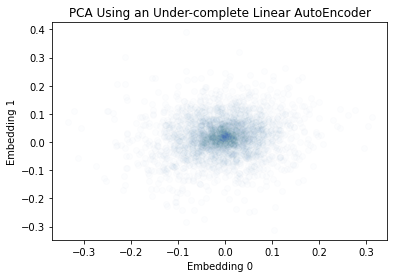

In [34]:
_ = plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.01)
_ = plt.xlabel("Embedding 0")
_ = plt.ylabel("Embedding 1")
_ = plt.title("PCA Using an Under-complete Linear AutoEncoder")

# Stacked autoencoders

In [40]:
class StackedAutoEncoder(pl.LightningModule):
    
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(INPUT_SIZE, 100),
            nn.ReLU(),
            nn.Linear(100, 32),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(32, 100),
            nn.ReLU(),
            nn.Linear(100, INPUT_SIZE),
            nn.Unflatten(dim=1, unflattened_size=INPUT_SHAPE)
        )

        self.autoencoder = nn.Sequential(
            *self.encoder,
            *self.decoder
        )
        
        self.loss_fn = nn.MSELoss()
        
    def forward(self, X):
        Z = self.autoencoder(X)
        return Z
    
    def training_step(self, batch, batch_idx):
        X, _ = batch
        Z = self.forward(X)
        loss = self.loss_fn(Z, X)
        self.log("train_loss", loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        X, _ = batch
        Z = self.forward(X)
        loss = self.loss_fn(Z, X)
        self.log("val_loss", loss, prog_bar=True)
        return loss
    
    def predict_step(self, batch, batch_idx):
        X, _ = batch
        reconstructions = self.forward(X)
        return reconstructions
    
    def configure_optimizers(self):
        return optim.SGD(self.parameters(), lr=1e-3)


In [41]:
stacked_autoencoder = StackedAutoEncoder()
torchinfo.summary(stacked_autoencoder)

Layer (type:depth-idx)                   Param #
StackedAutoEncoder                       --
├─Sequential: 1-1                        --
│    └─Flatten: 2-1                      --
│    └─Linear: 2-2                       307,300
│    └─ReLU: 2-3                         --
│    └─Linear: 2-4                       3,030
│    └─ReLU: 2-5                         --
├─Sequential: 1-2                        --
│    └─Linear: 2-6                       3,100
│    └─ReLU: 2-7                         --
│    └─Linear: 2-8                       310,272
│    └─Unflatten: 2-9                    --
├─Sequential: 1-3                        623,702
│    └─Flatten: 2-10                     --
│    └─Linear: 2-11                      (recursive)
│    └─ReLU: 2-12                        --
│    └─Linear: 2-13                      (recursive)
│    └─ReLU: 2-14                        --
│    └─Linear: 2-15                      (recursive)
│    └─ReLU: 2-16                        --
│    └─Linear: 2-17    

In [42]:
class LinearTranspose(nn.Module):
    
    def __init__(self, linear):
        super().__init__()
        self.weight = linear.weight
        self.bias = nn.Parameter(torch.zeros(self.weight.shape[1]))
        
    def forward(self, X):
        return X @ self.weight + self.bias


class StackedAutoEncoder(pl.LightningModule):
    
    def __init__(self):
        super().__init__()
        
        self.linear_1 = nn.Linear(INPUT_SIZE, 100)
        self.linear_2 = nn.Linear(100, 32)
        
        self.encoder = nn.Sequential(
            nn.Flatten(),
            self.linear_1,
            nn.ReLU(),
            self.linear_2,
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            LinearTranspose(self.linear_2),
            nn.ReLU(),
            LinearTranspose(self.linear_1),
            nn.Unflatten(dim=1, unflattened_size=INPUT_SHAPE)
        )

        self.autoencoder = nn.Sequential(
            *self.encoder,
            *self.decoder
        )
        
        self.loss_fn = nn.MSELoss()
        
    def forward(self, X):
        Z = self.autoencoder(X)
        return Z
    
    def training_step(self, batch, batch_idx):
        X, _ = batch
        Z = self.forward(X)
        loss = self.loss_fn(Z, X)
        self.log("train_loss", loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        X, _ = batch
        Z = self.forward(X)
        loss = self.loss_fn(Z, X)
        self.log("val_loss", loss, prog_bar=True)
        return loss
    
    def predict_step(self, batch, batch_idx):
        X, _ = batch
        reconstructions = self.forward(X)
        return reconstructions
    
    def configure_optimizers(self):
        return optim.SGD(self.parameters(), lr=1e-3)


In [43]:
stacked_autoencoder = StackedAutoEncoder()
torchinfo.summary(stacked_autoencoder)

Layer (type:depth-idx)                   Param #
StackedAutoEncoder                       --
├─Linear: 1-1                            307,300
├─Linear: 1-2                            3,030
├─Sequential: 1-3                        310,330
│    └─Flatten: 2-1                      --
│    └─Linear: 2-2                       (recursive)
│    └─ReLU: 2-3                         --
│    └─Linear: 2-4                       (recursive)
│    └─ReLU: 2-5                         --
├─Sequential: 1-4                        --
│    └─LinearTranspose: 2-6              3,100
│    └─ReLU: 2-7                         --
│    └─LinearTranspose: 2-8              310,272
│    └─Unflatten: 2-9                    --
├─Sequential: 1-5                        313,502
│    └─Flatten: 2-10                     --
│    └─Linear: 2-11                      (recursive)
│    └─ReLU: 2-12                        --
│    └─Linear: 2-13                      (recursive)
│    └─ReLU: 2-14                        --
│    └─Li

In [33]:
stacked_autoencoder = StackedAutoEncoder()

_trainer_kwargs = {
    "max_epochs": 100,
    "callbacks": [
        pl.callbacks.EarlyStopping("val_loss")
    ],
}
trainer = pl.Trainer(**_trainer_kwargs)

trainer.fit(stacked_autoencoder, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [13]:
predictions = trainer.predict(stacked_autoencoder, dataloaders=predictions_dataloader)

Predicting: 50it [00:00, ?it/s]

In [14]:
reconstructions = torch.cat(predictions, axis=0)

In [15]:
reconstructions.shape

torch.Size([3774, 3, 32, 32])

In [16]:
def plot_reconstructions(n_images=5):
    images = [unlabeled_dataset[n][0] for n in range(n_images)]
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index].permute(1, 2, 0))
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index].permute(1, 2, 0))
        plt.axis("off")

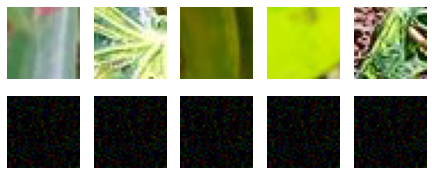

In [19]:
plot_reconstructions()

## Dimensionality reduction and data visualization

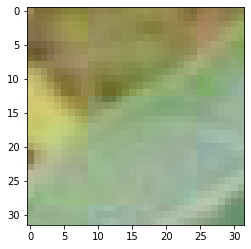

In [48]:
embeddings = autoencoder.encoder(???)
tsne = manifold.TSNE(init="pca", learning_rate="auto", random_state=42)
X_valid_2D = tsne.fit_transform(X_valid_compressed)

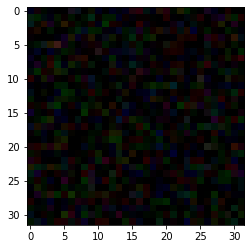

In [49]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.show()

# Unsupervised pretraining with stacked autoencoders

In [7]:
%%bash
EXTRACT_DIR=/kaggle/working/data/cassava-disease/
mkdir -p $EXTRACT_DIR 
unzip -qo /kaggle/input/cassava-disease/train.zip -d $EXTRACT_DIR
unzip -qo /kaggle/input/cassava-disease/test.zip -d $EXTRACT_DIR

In [31]:
labeled_train_dataset = datasets.ImageFolder(
    DATA_DIR / "train",
    transform=transform
)

test_dataset = datasets.ImageFolder(
    DATA_DIR / "test",
    transform=transform
)

dataloader_kwargs = {
    "batch_size": 32,
    "num_workers": 4,
}

labeled_train_dataloader = utils.data.DataLoader(
    labeled_train_dataset,
    shuffle=True,
    **dataloader_kwargs
)

predictions_dataloader = utils.data.DataLoader(
    test_dataset,
    shuffle=False,
    **dataloader_kwargs
)

In [32]:
class MLPClassifier(pl.LightningModule):
    
    def __init__(self, encoder):
        super().__init__()
        
        # freeze all the encoder parameters
        for p in encoder.parameters():
            p.requires_grad = False
        self.encoder_backbone = encoder
        
        self.classifier_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 5),
            nn.LogSoftmax(dim=1)
        )
        
        self.loss_fn = nn.NLLLoss()
        
    def forward(self, X):
        embeddings = self.encoder_backbone(X)
        logits = self.classifier_head(embeddings)
        return logits
    
    def training_step(self, batch, batch_idx):
        X, y = batch
        logits = self.forward(X)
        loss = self.loss_fn(logits, y)
        return loss
    
    def predict_step(self, batch, batch_idx):
        X, _ = batch
        logits = self.forward(X)
        return logits
    
    def configure_optimizers(self):
        return optim.SGD(self.parameters(), lr=1e-3)


In [33]:
classifier = MLPClassifier(stacked_autoencoder.encoder)

In [34]:
classifier

MLPClassifier(
  (encoder_backbone): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=100, bias=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=30, bias=True)
    (4): ReLU()
  )
  (classifier_head): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=30, out_features=100, bias=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): ReLU()
    (5): Linear(in_features=100, out_features=100, bias=True)
    (6): ReLU()
    (7): Linear(in_features=100, out_features=5, bias=True)
    (8): LogSoftmax(dim=1)
  )
  (loss_fn): NLLLoss()
)

In [35]:
_trainer_kwargs = {
    "max_epochs": 10,
}
trainer = pl.Trainer(**_trainer_kwargs)
trainer.fit(classifier, train_dataloaders=labeled_train_dataloader)

Training: 0it [00:00, ?it/s]

In [36]:
logits = trainer.predict(classifier, dataloaders=predictions_dataloader)

Predicting: 177it [00:00, ?it/s]

In [37]:
predictions = (torch.cat(logits, axis=0)
                    .argmax(axis=1))

In [39]:
predictions

tensor([3, 3, 3,  ..., 3, 3, 3])

# Denoising autoencoders

In [44]:
class DenoisingAutoEncoder(pl.LightningModule):
    
    def __init__(self):
        super().__init__()
        
        self.linear_1 = nn.Linear(INPUT_SIZE, 128)
        self.linear_2 = nn.Linear(128, 30)
        
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.5),
            self.linear_1,
            nn.ReLU(),
            self.linear_2,
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            LinearTranspose(self.linear_2),
            nn.ReLU(),
            LinearTranspose(self.linear_1),
            nn.Unflatten(dim=1, unflattened_size=INPUT_SHAPE)
        )

        self.autoencoder = nn.Sequential(
            *self.encoder,
            *self.decoder
        )
        
        self.loss_fn = nn.MSELoss()
        
    def forward(self, X):
        Z = self.autoencoder(X)
        return Z
    
    def training_step(self, batch, batch_idx):
        X, _ = batch
        Z = self.forward(X)
        loss = self.loss_fn(Z, X)
        return loss
    
    def predict_step(self, batch, batch_idx):
        X, _ = batch
        reconstructions = self.forward(X)
        return reconstructions
    
    def configure_optimizers(self):
        return optim.SGD(self.parameters(), lr=1e-3)


# Sparse Autoencoders

In [ ]:
class SparseAutoEncoder(pl.LightningModule):
    
    def __init__(self):
        super().__init__()
        
        self.linear_1 = nn.Linear(INPUT_SIZE, 128)
        self.linear_2 = nn.Linear(128, 32)
        
        self.encoder = nn.Sequential(
            nn.Flatten(),
            self.linear_1,
            nn.ReLU(),
            self.linear_2,
            nn.Sigmoid(),
        )

        self.decoder = nn.Sequential(
            LinearTranspose(self.linear_2),
            nn.ReLU(),
            LinearTranspose(self.linear_1),
            nn.Unflatten(dim=1, unflattened_size=INPUT_SHAPE)
        )

        self.autoencoder = nn.Sequential(
            *self.encoder,
            *self.decoder
        )
        
        self.activity_regularizer = nn.L1Loss()
        
        self.loss_fn = nn.MSELoss()
        
    def forward(self, X):
        Z = self.autoencoder(X)
        return Z
    
    def training_step(self, batch, batch_idx):
        X, _ = batch
        Z = self.forward(X)
        penalty = self.activity_regularizer(Z)
        loss = self.loss_fn(Z, X)
        return loss + penalty
    
    def predict_step(self, batch, batch_idx):
        X, _ = batch
        reconstructions = self.forward(X)
        return reconstructions
    
    def configure_optimizers(self):
        return optim.SGD(self.parameters(), lr=1e-3)


In [ ]:
class KLDivRegularizer(nn.Module):
    
    def __init__(self, weight, target):
        self.weight = weight
        self.target = target
        self.loss_fn = nn.KLDivLoss()

    def forward(self, X):
        mean_activities = torch.mean(inputs, axis=0)
        penalty = self.weight * (self.loss_fn(self.target, mean_activities) + self.loss_fn(1. - self.target, 1. - mean_activities))
        return penalty


In [ ]:
nn.K

# Variational Autoencoders

In [35]:
d = torch.distributions.Normal(0, 1)

In [36]:
d.sample?

Signature: d.sample(sample_shape=torch.Size([]))
Docstring:
Generates a sample_shape shaped sample or sample_shape shaped batch of
samples if the distribution parameters are batched.
File:      /opt/conda/lib/python3.7/site-packages/torch/distributions/normal.py
Type:      method


In [37]:
class Sample(nn.Module):
    
    def __init__(self,):
        super().__init__()

        self.distribution = torch.distributions.Normal(0, 1)
    
    def forward(self, means, log_vars):
        standard_normal_sample = self.distribution.sample(log_vars.shape)
        sample = standard_normal_sample * torch.exp(log_vars / 2) + means
        return sample 
    

class VariationalAutoEncoder(pl.LightningModule):
    
    def __init__(self):
        super().__init__()
        
        self.sample = Sample()
        self.emedding_means = nn.Linear(64, 32)
        self.embedding_log_vars = nn.Linear(64, 32)
        
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(INPUT_SIZE, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            self.sample(self.embeddings_means, self.embedding_log_vars)
        )
        
        
        self.decoder = nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, INPUT_SIZE),
            nn.Unflatten(dim=1, unflattened_size=INPUT_SHAPE)
        )

        self.autoencoder = nn.Sequential(
            *self.encoder,
            *self.decoder
        )
        
        self.reconstruction_loss_fn = nn.MSELoss()
        self.latent_loss_fn = nn.KLDivLoss()
        
    def forward(self, X):
        Z = self.autoencoder(X)
        return Z
    
    def training_step(self, batch, batch_idx):
        X, _ = batch
        Z = self.forward(X)
        reconstruction_loss = self.reconstruction_loss_fn(Z, X)
        latent_loss = self.latent_loss_fn(self.embedding_means, self.embedding_log_vars)
        return reconstruction_loss + latent_loss
    
    def predict_step(self, batch, batch_idx):
        X, _ = batch
        reconstructions = self.forward(X)
        return reconstructions
    
    def configure_optimizers(self):
        return optim.SGD(self.parameters(), lr=1e-3)


In [ ]:
inputs = tf.keras.layers.Input(shape=[28, 28])
Z = tf.keras.layers.Flatten()(inputs)
Z = tf.keras.layers.Dense(150, activation="relu")(Z)
Z = tf.keras.layers.Dense(100, activation="relu")(Z)
codings_mean = tf.keras.layers.Dense(codings_size)(Z)  # μ
codings_log_var = tf.keras.layers.Dense(codings_size)(Z)  # γ
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = tf.keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])